# Modeling with K Clustering and Regression 

In [79]:
# Import required libraries
import datetime
import time
from polygon import RESTClient
from sqlalchemy import create_engine 
from sqlalchemy import text
import pandas as pd
from math import sqrt
from math import isnan
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from math import floor
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split

# import pycaret
from pycaret.regression import *

In [80]:
curr = [['EUR', 'USD'],
        ['GBP', 'USD'],
        ['USD', 'CHF'],
        ['USD', 'CAD'],
        ['USD', 'HKD'],
        ['USD', 'AUD'],
        ['USD', 'NZD'],
        ['USD', 'SGD']]

In [81]:
# define a dictionary that we are going to use for storing sorted vol and fd parsing

dic_vol = {}
dic_fd = {}

In [82]:
# create engine to connect with 4 currency pairs database. 

engine1 = create_engine("sqlite+pysqlite:///../data/day1.db", echo=False, future=True)
engine2 = create_engine("sqlite+pysqlite:///../data/trailing.db", echo=False, future=True)
engine3 = create_engine("sqlite+pysqlite:///../data/final.db", echo=False, future=True)
engine4 = create_engine("sqlite+pysqlite:///../data/final_v2.db", echo=False, future=True)

## K_cluster and regression

In [92]:
# This is the function will find the the number of K clusters that optimized 
def find_k(curr, feature_list):
        with engine1.connect() as conn1:
                with engine2.connect() as conn2:
                        with engine3.connect() as conn3:
                                with engine4.connect() as conn4:
                                        df1 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn1)
                                        df2 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn2)
                                        df3 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn3)
                                        df4 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn4)
                                # clean up database1 and put in a dataframe
                                        df1 = df1[['avgfxrate', 'vol','fd','return_r']]
                                        df1 = df1.iloc[1:]
                                        df1= df1.reset_index(drop=True)
                                # clean up database2 and put in a dataframe
                                        df2 = df2[['avgfxrate', 'vol','fd','return_r']]
                                        df2 = df2.iloc[1:]
                                        df2= df2.reset_index(drop=True) 
                                # clean up database3 and put in a dataframe (VOL database3 is unconverted, and need to divide them by the mean)
                                        df3 = df3[['avgfxrate', 'vol','fd','return_r']]
                                        df3 = df3.iloc[1:]
                                        df3= df3.reset_index(drop=True)
                                # clean up database4 and put in a dataframe (VOL database3 is unconverted, and need to divide them by the mean)
                                        df4 = df4[['avgfxrate', 'vol','fd','return_r']]
                                        df4 = df4.iloc[1:]
                                        df4= df4.reset_index(drop=True)

                                # concatenate 4 database into our training dataframe
                                        training = pd.concat([df1, df2,df3, df4], ignore_index=True)

                                        scaler = MinMaxScaler()
                                        scaler.fit(training[['vol']])
                                        training['vol']= scaler.transform(training[['vol']])
                                
                                        scaler = MinMaxScaler()
                                        scaler.fit(training[['fd']])
                                        training['fd']= scaler.transform(training[['fd']])

                                        scaler = MinMaxScaler()
                                        scaler.fit(training[['avgfxrate']])
                                        training['mean']= scaler.transform(training[['avgfxrate']])

                                        k_rng = range(1,11)
                                        sse = []
                                        for k in k_rng:
                                                km = KMeans(n_clusters=k)
                                                km.fit(training[feature_list])
                                                sse.append(km.inertia_)

                                        plt.xlabel('k')
                                        plt.ylabel('sum of squared error')
                                        plt.plot(k_rng, sse, label=curr[0]+curr[1])
                                        

In [55]:
# This function will return the model ready dataframe. 
def Model_ready_data(curr, n_cluster, feature_list1, feature_list2):
    with engine1.connect() as conn1:
        with engine2.connect() as conn2:
            with engine3.connect() as conn3:
                with engine4.connect() as conn4:
                    df1 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn1)
                    df2 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn2)
                    df3 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn3)
                    df4 = pd.read_sql_table(curr[0]+curr[1]+"_agg",conn4)
            # clean up database1 and put in a dataframe
                    df1 = df1[['avgfxrate', 'vol','fd','return_r']]
                    df1 = df1.iloc[1:]
                    df1= df1.reset_index(drop=True)
            # clean up database2 and put in a dataframe
                    df2 = df2[['avgfxrate', 'vol','fd','return_r']]
                    df2 = df2.iloc[1:]
                    df2= df2.reset_index(drop=True) 
            # clean up database3 and put in a dataframe (VOL database3 is unconverted, and need to divide them by the mean)
                    df3 = df3[['avgfxrate', 'vol','fd','return_r']]
                    df3 = df3.iloc[1:]
                    df3= df3.reset_index(drop=True)
            # clean up database4 and put in a dataframe (VOL database3 is unconverted, and need to divide them by the mean)
                    df4 = df4[['avgfxrate', 'vol','fd','return_r']]
                    df4 = df4.iloc[1:]
                    df4= df4.reset_index(drop=True)
        
            # concatenate 4 database into our training dataframe
                    training = pd.concat([df1, df2,df3, df4], ignore_index=True)

                    scaler = MinMaxScaler()
                    scaler.fit(training[['vol']])
                    training['vol']= scaler.transform(training[['vol']])
                
                    scaler = MinMaxScaler()
                    scaler.fit(training[['fd']])
                    training['fd']= scaler.transform(training[['fd']])

                    scaler = MinMaxScaler()
                    scaler.fit(training[['avgfxrate']])
                    training['mean']= scaler.transform(training[['avgfxrate']])

                # we can see that 3 is optumin
                    km = KMeans(n_clusters=n_cluster)
                    training['cluster1']= km.fit_predict(training[feature_list1])
                    training['cluster2']= km.fit_predict(training[feature_list2])


                # After coding to vol and fd in to [1,2,3], we need multiple the reurn by 10,000 to normalize the training output
                    training['return_r_label'] = training['return_r'].apply(lambda x: x * 10000)


                # Assign to our newly proccessed training dataset
                    training = training[['avgfxrate', 'cluster1', 'cluster2','return_r_label']]
                    return training

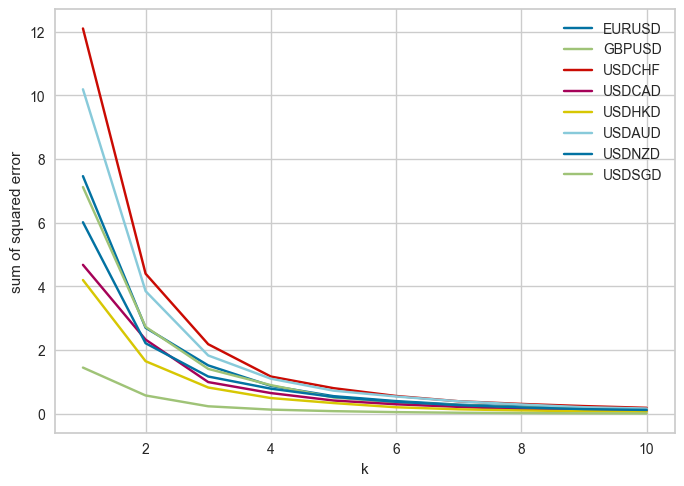

In [93]:
# Use the The Elbow Method to determine the optimal number of clusters
for i in range(8):
    find_k(curr[i], ['vol'])
    plt.legend()


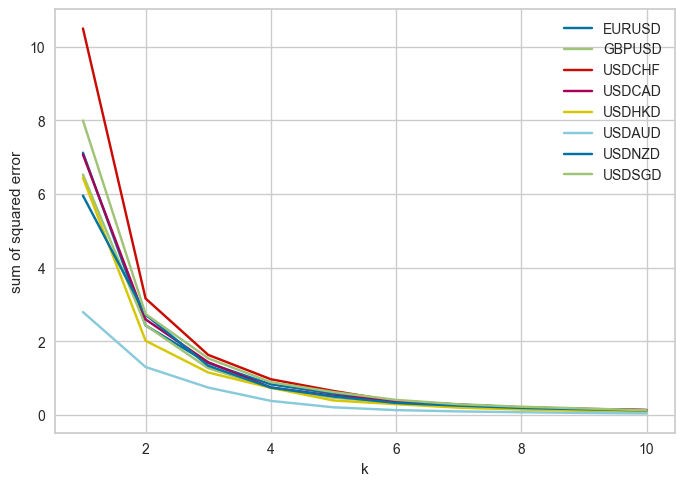

In [94]:
for i in range(8):
    find_k(curr[i], ['fd'])
    plt.legend()


In [102]:
# Regression Modeling
for i in range(8):
    training = Model_ready_data(curr[i], 2, ['vol'], ['fd'])

    # we will init our categorical features and numeric features into a list
    cate_features = ['cluster1', 'cluster2']
    num_features = ['avgfxrate']

    # Now starting to model with Pycaret regression 
    s = setup(data=training, target='return_r_label', categorical_features=cate_features, numeric_features=num_features)
    # we have to exclude the following regression models because they don't generate predictions. 
    best = compare_models(exclude=['llar','dummy','lasso', 'en'])
    model = tune_model(best)
 
    evaluate_model(model)


,Description,Value
0,Session id,6462
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.4438,13.9048,3.5675,-0.0360,1.0337,2.2253,0.0110
huber,Huber Regressor,2.4592,13.9803,3.5826,-0.0489,1.0293,3.8686,0.0130
ridge,Ridge Regression,2.4565,14.0473,3.5889,-0.0506,0.9905,3.6687,0.0160
lr,Linear Regression,2.4636,14.0885,3.5988,-0.0598,0.9875,5.0666,0.0450
lar,Least Angle Regression,2.4636,14.0885,3.5988,-0.0598,0.9875,5.0666,0.0120
omp,Orthogonal Matching Pursuit,2.4524,14.1373,3.6061,-0.0641,1.0042,3.6791,0.0120
knn,K Neighbors Regressor,2.7192,16.2003,3.8451,-0.2124,0.7858,13.4389,0.0130
lightgbm,Light Gradient Boosting Machine,2.6696,15.5008,3.8078,-0.2188,0.8494,7.4221,0.0140
ada,AdaBoost Regressor,2.6528,16.2453,3.8776,-0.3051,0.8758,5.4387,0.0190
gbr,Gradient Boosting Regressor,2.8168,16.9098,3.9710,-0.3463,0.8220,8.2439,0.0180


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3669,11.2307,3.3512,-0.0437,1.1792,0.9963
1,2.6767,12.5063,3.5364,-0.0385,1.2663,1.0003
2,3.4189,19.4641,4.4118,-0.0082,1.4268,0.9976
3,2.4395,13.9726,3.7380,-0.0125,1.1825,0.9744
4,1.7162,6.2701,2.5040,-0.0194,0.9868,1.0681
5,2.3593,8.6834,2.9468,-0.0178,1.1866,0.9993
6,3.0070,38.4060,6.1973,-0.0018,1.2491,0.9617
7,2.0972,8.5199,2.9189,-0.1944,1.1134,1.3358
8,1.6634,4.6321,2.1522,-0.0013,0.9762,1.0001


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,1743
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,3.0152,16.5758,4.0435,-0.0442,1.0843,1.6286,0.0100
lr,Linear Regression,3.0169,16.6889,4.0543,-0.0485,1.0544,1.7245,0.0390
lar,Least Angle Regression,3.0169,16.6889,4.0543,-0.0485,1.0544,1.7245,0.0140
huber,Huber Regressor,3.0022,16.7467,4.0611,-0.0519,1.0861,1.3739,0.0140
br,Bayesian Ridge,2.9984,16.7556,4.0673,-0.0560,1.2258,1.1552,0.0120
ridge,Ridge Regression,2.9908,16.8049,4.0708,-0.0569,1.1751,1.1034,0.0150
ada,AdaBoost Regressor,3.0153,16.9192,4.0841,-0.0680,0.9413,1.9052,0.0150
lightgbm,Light Gradient Boosting Machine,3.1449,18.2455,4.2374,-0.1512,0.8574,2.9903,0.0130
gbr,Gradient Boosting Regressor,3.2842,19.3188,4.3455,-0.2161,0.9016,4.1274,0.0160
knn,K Neighbors Regressor,3.3541,20.1754,4.4662,-0.2796,0.8596,2.5436,0.0130


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7023,11.3447,3.3682,0.0372,1.1106,1.5304
1,2.9853,15.4243,3.9274,-0.0284,1.0648,2.7466
2,2.6934,11.8637,3.4444,-0.0770,1.0110,1.4285
3,2.9758,15.4451,3.9300,0.0059,1.1236,1.2612
4,2.9803,15.3500,3.9179,0.0024,1.0387,2.6918
5,3.2704,22.7281,4.7674,-0.0122,1.1457,0.8940
6,3.9106,24.4927,4.9490,-0.3479,1.1330,1.1581
7,3.1155,17.1199,4.1376,-0.0228,1.1230,1.2176
8,2.8126,14.7782,3.8442,0.0325,1.0730,1.4614


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,1658
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.0000,7.9195,2.7853,-0.0498,0.9620,2.1017,0.0110
huber,Huber Regressor,2.0198,8.0040,2.8000,-0.0618,0.9396,2.7307,0.0110
ridge,Ridge Regression,2.0194,8.0035,2.8008,-0.0625,0.9395,2.5928,0.0160
lr,Linear Regression,2.0177,8.0131,2.8016,-0.0626,0.9262,2.4838,0.0400
lar,Least Angle Regression,2.0177,8.0131,2.8016,-0.0626,0.9262,2.4838,0.0130
omp,Orthogonal Matching Pursuit,2.0122,8.0161,2.8024,-0.0632,0.9415,2.7702,0.0130
ada,AdaBoost Regressor,2.0735,8.6670,2.9123,-0.1484,0.8548,2.2788,0.0210
lightgbm,Light Gradient Boosting Machine,2.2388,9.5199,3.0502,-0.2650,0.7698,6.2069,0.0140
knn,K Neighbors Regressor,2.2851,9.6778,3.0771,-0.3084,0.7144,9.0543,0.0130
gbr,Gradient Boosting Regressor,2.3740,11.6952,3.3480,-0.5194,0.7505,6.2672,0.0160


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3440,9.2426,3.0402,-0.1239,1.1525,1.0045
1,2.0737,7.6437,2.7647,-0.0463,1.0989,0.9823
2,2.3147,10.6481,3.2631,-0.0870,1.1631,0.9733
3,2.1814,8.1322,2.8517,-0.0043,1.1373,1.1866
4,1.4158,4.3555,2.0870,0.0016,0.8746,1.2427
5,1.5809,4.5192,2.1258,-0.0048,0.9482,1.0639
6,1.9889,7.4092,2.7220,-0.0563,1.0825,1.3564
7,2.3086,9.4657,3.0766,-0.0741,1.1775,1.0333
8,1.8313,6.4775,2.5451,-0.0233,1.0044,1.0164


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,6824
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.8397,5.8283,2.3864,-0.0078,0.7874,2.1297,0.0110
lr,Linear Regression,1.8561,5.9039,2.4040,-0.0259,0.7720,1.7521,0.0420
lar,Least Angle Regression,1.8561,5.9039,2.4040,-0.0259,0.7720,1.7521,0.0110
br,Bayesian Ridge,1.8840,6.0135,2.4212,-0.0355,1.0075,1.1330,0.0100
ada,AdaBoost Regressor,1.8954,6.0990,2.4353,-0.0458,0.8410,1.9311,0.0160
ridge,Ridge Regression,1.9033,6.1092,2.4419,-0.0549,0.9829,1.4756,0.0200
huber,Huber Regressor,1.8825,6.1289,2.4509,-0.0714,0.8148,1.6234,0.0130
lightgbm,Light Gradient Boosting Machine,1.9642,6.6005,2.5329,-0.1318,0.7220,3.0477,0.0130
knn,K Neighbors Regressor,2.0060,6.8546,2.5800,-0.1759,0.6988,2.4569,0.0150
gbr,Gradient Boosting Regressor,2.0381,7.0778,2.6206,-0.2142,0.7083,2.8771,0.0180


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1127,7.8293,2.7981,0.0585,0.8583,1.5073
1,1.7205,5.2963,2.3014,-0.0042,0.7294,9.0566
2,1.1491,2.3764,1.5416,0.0489,0.5976,1.1347
3,2.1873,6.6862,2.5858,-0.0044,0.8858,1.0248
4,2.0029,5.4344,2.3312,-0.0678,0.8479,1.1228
5,2.1572,8.7219,2.9533,0.0485,0.9542,1.1031
6,1.8532,4.8661,2.2059,-0.0284,0.7699,2.1611
7,1.7396,5.5001,2.3452,-0.0970,0.7139,1.8589
8,1.5162,5.0739,2.2525,-0.0397,0.6954,1.3090


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,954
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.5829,0.8397,0.9091,-0.0551,0.4661,2.8510,0.0100
br,Bayesian Ridge,0.5752,0.8462,0.9132,-0.0658,0.5043,1.6280,0.0120
lr,Linear Regression,0.5940,0.8863,0.9335,-0.1116,0.4547,2.9727,0.0480
lar,Least Angle Regression,0.5940,0.8863,0.9335,-0.1116,0.4547,2.9727,0.0110
lightgbm,Light Gradient Boosting Machine,0.6407,0.8858,0.9340,-0.1173,0.4088,11.4337,0.0130
ridge,Ridge Regression,0.5836,0.8888,0.9355,-0.1176,0.4844,1.3636,0.0170
huber,Huber Regressor,0.5966,0.9342,0.9597,-0.1822,0.4749,1.7438,0.0120
ada,AdaBoost Regressor,0.6515,1.0451,1.0040,-0.2895,0.4351,11.2223,0.0170
knn,K Neighbors Regressor,0.6785,1.1086,1.0425,-0.3912,0.3729,10.3592,0.0140
gbr,Gradient Boosting Regressor,0.7299,1.4060,1.1523,-0.7019,0.4230,10.1598,0.0160


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6689,0.9010,0.9492,-0.2586,0.5021,1.7489
1,0.4230,0.6878,0.8293,-0.0208,0.3760,1.2582
2,0.5070,0.5489,0.7409,-0.0200,0.4235,1.4950
3,0.6733,0.9542,0.9768,-0.1186,0.4874,4.3237
4,0.5989,0.7338,0.8566,0.0108,0.4733,1.6066
5,0.5406,0.7172,0.8469,0.0184,0.4568,2.0097
6,0.6448,1.1302,1.0631,-0.0499,0.4915,9.5759
7,0.6298,1.2425,1.1147,-0.0344,0.5272,2.0378
8,0.5276,0.6029,0.7765,-0.0380,0.4245,1.0684


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,6177
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,3.3505,18.9004,4.2742,-0.0265,1.3490,1.0181,0.0110
ada,AdaBoost Regressor,3.3670,18.9016,4.2750,-0.0305,1.0479,1.1862,0.0170
omp,Orthogonal Matching Pursuit,3.3656,19.0095,4.2858,-0.0322,1.2210,1.0669,0.0110
ridge,Ridge Regression,3.3691,19.1297,4.2992,-0.0384,1.3188,1.0434,0.0150
lr,Linear Regression,3.3748,19.1121,4.2986,-0.0394,1.1989,1.0811,0.0410
lar,Least Angle Regression,3.3748,19.1121,4.2986,-0.0394,1.1989,1.0811,0.0110
huber,Huber Regressor,3.3859,19.2121,4.3090,-0.0436,1.2296,1.1053,0.0130
lightgbm,Light Gradient Boosting Machine,3.5401,21.2012,4.5132,-0.1400,0.9626,1.4355,0.0150
gbr,Gradient Boosting Regressor,3.6542,21.7871,4.5986,-0.2037,0.9117,1.8669,0.0180
par,Passive Aggressive Regressor,3.6022,21.6711,4.5902,-0.2181,0.9751,1.5796,0.0110


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.5503,10.2275,3.1981,-0.0138,1.2513,1.0001
1,4.0121,28.0388,5.2952,-0.0246,1.5411,1.0001
2,3.5983,18.9884,4.3576,-0.0048,1.4890,1.0001
3,3.6670,23.6122,4.8592,-0.0003,1.4746,1.0000
4,4.2618,30.4041,5.5140,-0.0020,1.5956,1.0000
5,3.4702,17.8161,4.2209,-0.0020,1.4623,0.9999
6,2.7836,10.9316,3.3063,-0.0000,1.3095,1.0000
7,3.3181,22.6022,4.7542,-0.0390,1.3896,1.0000
8,2.5979,11.6072,3.4069,-0.0436,1.2549,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,3311
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,3.4608,20.9695,4.5061,-0.0249,1.1381,1.3250,0.0180
omp,Orthogonal Matching Pursuit,3.4709,21.0770,4.5170,-0.0291,1.1535,1.2834,0.0120
br,Bayesian Ridge,3.4781,21.0792,4.5177,-0.0298,1.2529,1.1379,0.0130
lr,Linear Regression,3.4673,21.0626,4.5168,-0.0302,1.1319,1.3683,0.0450
lar,Least Angle Regression,3.4673,21.0626,4.5168,-0.0302,1.1319,1.3683,0.0120
huber,Huber Regressor,3.4552,21.1003,4.5218,-0.0346,1.0265,1.4857,0.0130
ada,AdaBoost Regressor,3.5225,22.1784,4.6193,-0.0734,1.0351,1.3761,0.0190
lightgbm,Light Gradient Boosting Machine,3.6850,23.7170,4.7967,-0.1735,0.9858,1.8799,0.0150
knn,K Neighbors Regressor,3.8369,25.5868,4.9963,-0.2818,0.8949,2.5740,0.0150
gbr,Gradient Boosting Regressor,3.9522,27.1948,5.1231,-0.3434,0.9405,2.1162,0.0180


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5073,23.5738,4.8553,-0.0348,1.3031,1.0928
1,3.0956,14.3070,3.7825,-0.0161,1.2408,1.5512
2,4.7502,39.5187,6.2864,-0.0626,1.3809,1.1488
3,3.9017,24.4426,4.9439,-0.0254,1.3086,0.9530
4,2.3624,9.0031,3.0005,0.0097,1.0391,0.9544
5,3.1819,17.3039,4.1598,-0.0391,1.2818,0.9664
6,3.5182,23.2733,4.8242,-0.0302,1.2636,1.1089
7,3.5198,18.4424,4.2945,0.0037,1.3669,1.1094
8,3.3275,18.0703,4.2509,-0.0232,1.3224,1.0781


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Description,Value
0,Session id,3581
1,Target,return_r_label
2,Target type,Regression
3,Data shape,"(396, 4)"
4,Train data shape,"(277, 4)"
5,Test data shape,"(119, 4)"
6,Ordinal features,2
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,1.7368,7.5154,2.5338,-0.0377,0.9162,1.0880,0.0120
br,Bayesian Ridge,1.7387,7.5030,2.5335,-0.0392,0.9261,1.1612,0.0130
ridge,Ridge Regression,1.7371,7.4999,2.5333,-0.0398,0.8912,1.2043,0.0150
huber,Huber Regressor,1.7446,7.5236,2.5387,-0.0456,0.8792,1.2486,0.0130
lr,Linear Regression,1.7474,7.5555,2.5432,-0.0483,0.9038,1.2459,0.0470
lar,Least Angle Regression,1.7474,7.5555,2.5432,-0.0483,0.9038,1.2459,0.0120
ada,AdaBoost Regressor,1.7755,7.6420,2.5541,-0.0525,0.8477,1.5017,0.0160
gbr,Gradient Boosting Regressor,1.9307,8.4903,2.7275,-0.2379,0.7639,2.3849,0.0190
lightgbm,Light Gradient Boosting Machine,1.8899,8.1543,2.6884,-0.2556,0.7677,2.1731,0.0140
knn,K Neighbors Regressor,1.9702,8.7681,2.7834,-0.3070,0.7066,2.0788,0.0150


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4505,4.4022,2.0982,-0.0276,0.8157,1.1881
1,2.8085,30.0614,5.4828,-0.0079,1.1370,1.0380
2,1.9182,6.6271,2.5743,-0.0004,0.9820,1.1078
3,1.7468,5.1838,2.2768,-0.0055,0.9533,0.9403
4,1.2839,2.4320,1.5595,-0.1816,0.6976,1.1735
5,1.5233,4.7079,2.1698,-0.0052,0.8800,1.0965
6,1.5196,3.5745,1.8906,-0.0032,0.8419,1.0691
7,2.0222,6.9192,2.6304,-0.0526,1.0723,1.0056
8,1.6146,7.4006,2.7204,-0.0034,0.8958,1.0161


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…